In [1]:
import time
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


import warnings
warnings.filterwarnings("ignore")

In [2]:
def restore_differenced(periods, df_original, df_differences):
    '''
    from: https://stackoverflow.com/questions/34918013/undo-a-series-diff
    '''
    restored = df_original.copy()
    restored.iloc[periods:] = np.nan
    for d, val in df_differences.iloc[periods:].iterrows():
        restored.iloc[d] = restored.iloc[d - periods] + val
    return restored

In [3]:
def log_score_function(actual, predicted, var):
    '''
    Function that calculates the log scoring function:
    
    L = 0.5 * sum_j (ln(var_j) + (y - y_hat)^2 / var_j)
    
    '''
    var[var == 0] = np.nan
    const = np.log(2 * np.pi)
    L = 0.5 * np.nansum(np.log(var) + (actual - predicted)**2 / var + const, axis=1)
    return L

In [4]:
n_sys_VAR = 100
n_data_VAR = 50000

In [5]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
data_multiple = data.iloc[:, :n_sys_VAR][:n_data_VAR]
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.reset_index().columns)].set_index('ss_id_string')['kwp'].values * 1000


# Do the same for other benchmarks

## Uncertainty Intervals

By using a state space formulation, we can perform simulations of future values. The mathematical details are described in Hyndman and Athanasopoulos [2] and in the documentation of HoltWintersResults.simulate.

Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice, 2nd edition. OTexts, 2018.

In [19]:
models_list = ['persistence','yesterday','hourly_average' , 'VAR', 'SimpleExpSmoothing', 'ExponentialSmoothing',]

MAE_results = dict.fromkeys(models_list)
NLPD_results = dict.fromkeys(models_list)
NLPD_results_upper = dict.fromkeys(models_list)
NLPD_results_lower = dict.fromkeys(models_list)
predictions_results = dict.fromkeys(models_list)

#FIXED WINDOW OF 5000 train and 24 test, the 5000 train slide forward
length_window = 97 * 10
max_t = 14000 #len(data_multiple) - length_window - 24
#HERE BUILDING ARRAY OF STARTING ts
data_multiple.index = pd.to_datetime(data_multiple.index)
array_of_indices = data_multiple.reset_index()[(data_multiple.reset_index().datetime.dt.hour > 9) & (data_multiple.reset_index().datetime.dt.hour < 14)].index.values
range_idx = array_of_indices[10000:max_t:50]
        
for model_type in models_list:
    print(f'Getting results for {model_type}')
    t1 = time.time()

    errors = np.zeros((24, n_sys_VAR))
    predictions_history = np.zeros((24, n_sys_VAR))
    nlpds = np.zeros((24))
    
    for t in range_idx:
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        if model_type == 'VAR':

            data_VAR = data_multiple_train.diff().diff(97).dropna()

            #CREATE MODEL AND PREDICT NEXT 24
            model = VAR(data_VAR)
            model_fit = model.fit()
            lag_order = model_fit.k_ar
            preds = model_fit.forecast(data_VAR.values[-lag_order:], 24)
            if len(preds[preds>10]) > 0:
                print('Careful, a prediction is higher than 10!')
            #evaluate forecast
            df_forecast = pd.DataFrame(preds, index=data_multiple_test.index, columns=data_VAR.columns)

            data_total = pd.concat([data_VAR,df_forecast], axis=0).reindex(data_multiple_iter.index).reset_index().drop(columns = ['datetime'])

            data_reset = data_total.iloc[1:].reset_index().drop(columns=['index'])
            restored = restore_differenced(97, data_multiple_iter.diff().dropna(), data_reset)
            restored = restored.reindex(data_multiple_iter.index).reset_index().drop(columns=['datetime'])
            restored_twice = restore_differenced(1, data_multiple_iter, restored)

            #CLIPPING PREDICTIONS BETWEEN 0 AND 1
            restored_twice = restored_twice.clip(0,1)
            predictions = restored_twice.iloc[-24:]    

        elif model_type == 'persistence':
            predictions = data_multiple_train.iloc[-1].values
            predictions =  np.repeat(predictions[np.newaxis, :], 24, axis=0)

        elif model_type == 'yesterday':
            predictions = np.zeros((1,n_sys_VAR))
            previous_day = data_multiple_train.iloc[-97:].values
            for i in range(24):
                pred = previous_day[-97 + i][np.newaxis, :]
                predictions = np.concatenate((predictions, pred))
            predictions = predictions[1:]

        elif model_type == 'hourly_average':
            predictions = np.zeros((1,n_sys_VAR))
            previous_hour = data_multiple_train.iloc[-12:].values
            for i in range(24):
                pred = previous_hour.mean(axis=0)[np.newaxis, :]
                predictions = np.concatenate((predictions, pred))
                #HERE I append the latest prediction and remove the oldest observation
                previous_hour = np.concatenate((previous_hour, pred), axis=0)[1:]
            predictions = predictions[1:]
            
            
        elif model_type == 'SimpleExpSmoothing':
            predictions = np.zeros((24, 1))
            variances = np.zeros((24, 1))
            for ts in range(data_multiple_train.shape[1]):
                model = SimpleExpSmoothing(data_multiple_train.iloc[:,ts], initialization_method="estimated")
                model_fit = model.fit()
                
                fcast = model_fit.forecast(24).values[:, np.newaxis]
                predictions = np.concatenate((predictions, fcast), axis=1)
                
                var = model_fit.simulate(nsimulations = 24, anchor = 'end', repetitions = 1000 ).var(axis=1).values[:, np.newaxis]
                
                var_low_bound = (fcast**2 / 4)
                var_upper_bound = ((1-fcast)**2 / 4)
                var = np.maximum(var_low_bound, var)
                var = np.minimum(var_upper_bound, var)
                
                variances = np.concatenate((variances, var), axis=1)
                
                
            predictions = predictions[:, 1:]
            variances = variances[:, 1:]
            
            nlpd = log_score_function(data_multiple_iter.iloc[-24:].values, predictions, variances) 
            nlpds = np.concatenate((nlpds, nlpd))   
            
            
        elif model_type == 'ExponentialSmoothing':
            predictions = np.zeros((24, 1))
            variances = np.zeros((24, 1))
            for ts in range(data_multiple_train.shape[1]):
                model = ExponentialSmoothing(data_multiple_train.iloc[:,ts], 
                                             seasonal_periods=97,
                                             seasonal="add",
                                             initialization_method="estimated")
                model_fit = model.fit()
                fcast = model_fit.forecast(24).values[:, np.newaxis]
                predictions = np.concatenate((predictions, fcast), axis=1)
                
                var = model_fit.simulate(nsimulations = 24, anchor = 'end', repetitions = 1000 ).var(axis=1).values[:, np.newaxis]
                
                var_low_bound = (fcast**2 / 4)
                var_upper_bound = ((1-fcast)**2 / 4)
                var = np.maximum(var_low_bound, var)
                var = np.minimum(var_upper_bound, var)
                
                variances = np.concatenate((variances, var), axis=1)
                
            predictions = predictions[:, 1:]
            variances = variances[:, 1:]
            
            nlpd = log_score_function(data_multiple_iter.iloc[-24:].values, predictions, variances) 
            nlpds = np.concatenate((nlpds, nlpd))   

            
        #THIS WAY WE REDUCE THE ERROR FURTHER USING A SIMPLE TRICK OF CLIPPING PREDICTIONS OUTSIDE DOMAIN
        predictions = predictions.clip(0,1)
        predictions_history = np.concatenate((predictions_history, predictions))    
        
        #Get error
        error = abs((predictions - data_multiple_iter.iloc[-24:]).values)
        errors = np.concatenate((errors, error))       
        
        t2 = time.time()
        print(f'{model_type} calculation time: %2.2f secs' % (t2-t1))

    predictions_history = predictions_history.reshape(-1, 24, n_sys_VAR)[1:]
    predictions_results[model_type] = predictions_history
    
    errors = errors.reshape(-1, 24, n_sys_VAR)[1:]
    MAE_hsteps = np.mean(np.mean(errors, axis=0), axis=1)    
    MAE_results[model_type] = MAE_hsteps
    
    if (model_type == 'SimpleExpSmoothing') or (model_type == 'ExponentialSmoothing'):
        nlpds = nlpds.reshape(-1, 24)[1:]
        NLPD_results[model_type] = np.quantile(nlpds, 0.5, axis=0)
        NLPD_results_upper[model_type] = np.quantile(nlpds, 0.975, axis=0)
        NLPD_results_lower[model_type] = np.quantile(nlpds, 0.025, axis=0)

        

Getting results for persistence
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.00 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persistence calculation time: 0.01 secs
persiste

VAR calculation time: 0.39 secs
VAR calculation time: 0.75 secs
VAR calculation time: 1.16 secs
VAR calculation time: 1.56 secs
VAR calculation time: 1.94 secs
VAR calculation time: 2.24 secs
VAR calculation time: 2.72 secs
VAR calculation time: 3.05 secs
VAR calculation time: 3.39 secs
VAR calculation time: 3.75 secs
VAR calculation time: 4.13 secs
VAR calculation time: 4.48 secs
VAR calculation time: 4.90 secs
VAR calculation time: 5.30 secs
VAR calculation time: 5.81 secs
VAR calculation time: 6.25 secs
VAR calculation time: 6.64 secs
VAR calculation time: 6.94 secs
VAR calculation time: 7.25 secs
VAR calculation time: 7.53 secs
VAR calculation time: 7.89 secs
VAR calculation time: 8.29 secs
VAR calculation time: 8.76 secs
VAR calculation time: 9.01 secs
VAR calculation time: 9.42 secs
VAR calculation time: 9.72 secs
VAR calculation time: 10.02 secs
VAR calculation time: 10.37 secs
VAR calculation time: 10.65 secs
VAR calculation time: 11.03 secs
VAR calculation time: 11.39 secs
VAR

ExponentialSmoothing calculation time: 535.88 secs
ExponentialSmoothing calculation time: 549.37 secs
ExponentialSmoothing calculation time: 563.20 secs
ExponentialSmoothing calculation time: 577.41 secs
ExponentialSmoothing calculation time: 590.54 secs
ExponentialSmoothing calculation time: 604.23 secs
ExponentialSmoothing calculation time: 618.61 secs
ExponentialSmoothing calculation time: 632.97 secs
ExponentialSmoothing calculation time: 647.95 secs
ExponentialSmoothing calculation time: 661.95 secs
ExponentialSmoothing calculation time: 675.94 secs
ExponentialSmoothing calculation time: 689.58 secs
ExponentialSmoothing calculation time: 702.90 secs
ExponentialSmoothing calculation time: 715.69 secs
ExponentialSmoothing calculation time: 729.05 secs
ExponentialSmoothing calculation time: 742.36 secs
ExponentialSmoothing calculation time: 755.78 secs
ExponentialSmoothing calculation time: 769.61 secs
ExponentialSmoothing calculation time: 782.57 secs
ExponentialSmoothing calculatio

# Results

## NLPD 

(-100.0, 100.0)

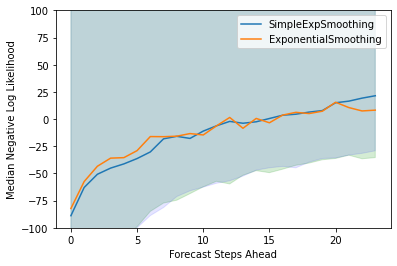

In [44]:
NLPD_df = pd.DataFrame.from_dict(NLPD_results)
NLPD_df_upper = pd.DataFrame.from_dict(NLPD_results_upper)
NLPD_df_lower = pd.DataFrame.from_dict(NLPD_results_lower)

NLPD_df.plot()

plt.fill_between(NLPD_df_upper.index,
        NLPD_df_upper.SimpleExpSmoothing,
        NLPD_df_lower.SimpleExpSmoothing,
        color="C2",
        alpha=0.2)

plt.fill_between(NLPD_df_upper.index,
        NLPD_df_upper.ExponentialSmoothing,
        NLPD_df_lower.ExponentialSmoothing,
        color="blue",
        alpha=0.1)
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Median Negative Log Likelihood')

plt.ylim(-100,100)


(-100.0, 100.0)

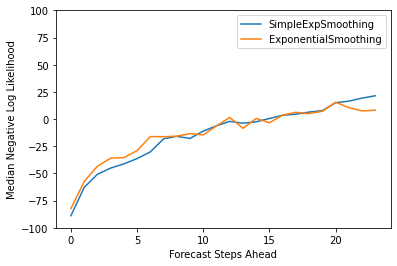

In [42]:
NLPD_df = pd.DataFrame.from_dict(NLPD_results)
NLPD_df_upper = pd.DataFrame.from_dict(NLPD_results_upper)
NLPD_df_lower = pd.DataFrame.from_dict(NLPD_results_lower)
NLPD_df.plot()
plt.xlabel('Forecast Steps Ahead')
plt.ylabel('Median Negative Log Likelihood')
plt.ylim(-100,100)

SimpleExpSmoothing     -5.010640
ExponentialSmoothing   -7.347641
dtype: float64

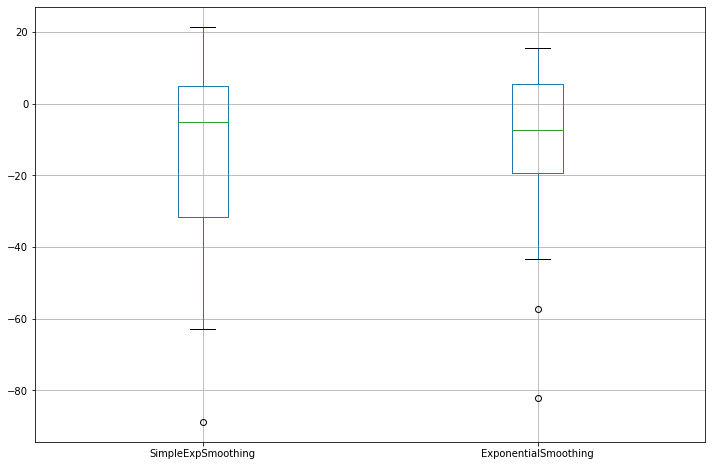

In [39]:
plt.figure(figsize=(12,8))
NLPD_df.boxplot()
NLPD_df.median().dropna()

# MAE

persistence             0.130540
yesterday               0.203255
hourly_average          0.128039
VAR                     0.168293
SimpleExpSmoothing      0.127407
ExponentialSmoothing    0.129967
dtype: float64

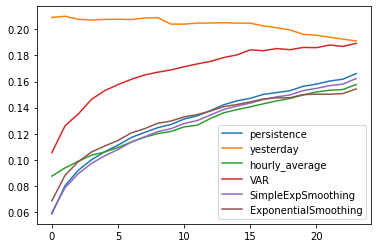

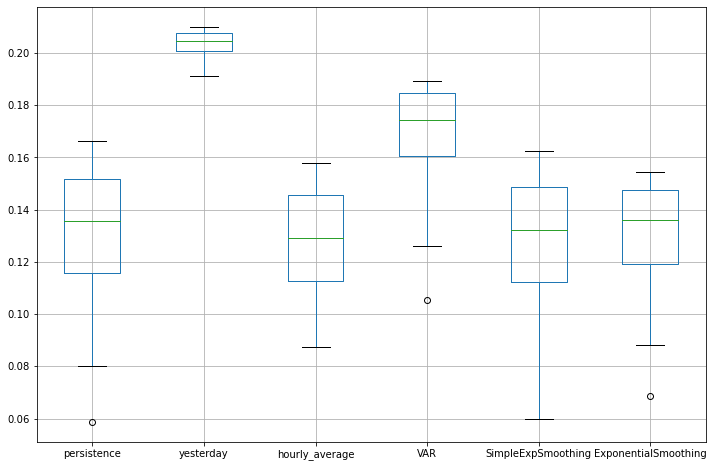

In [40]:
MAE_df = pd.DataFrame.from_dict(MAE_results)
MAE_df.plot()
plt.figure(figsize=(12,8))
MAE_df.boxplot()
MAE_df.mean()

## Plotting SimpleExpSmoothing Preds

PLOTTING SYSTEM 0


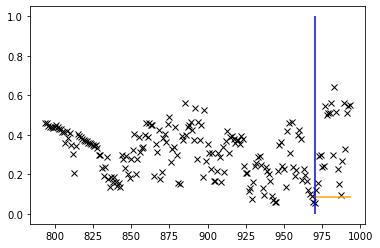

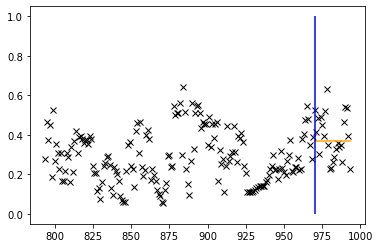

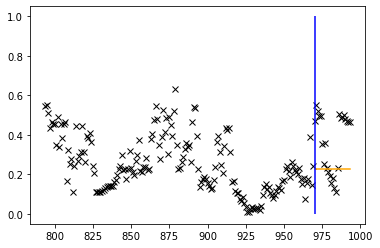

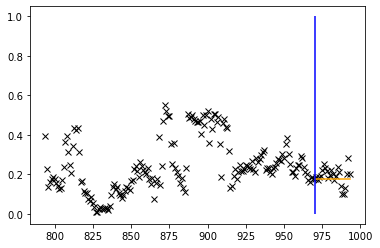

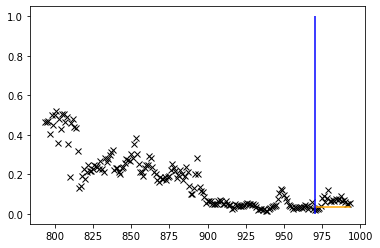

PLOTTING SYSTEM 1


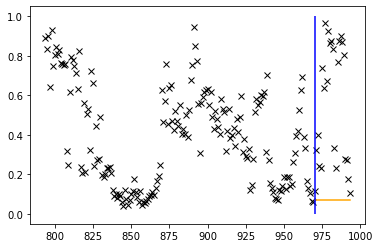

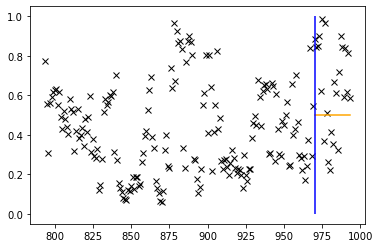

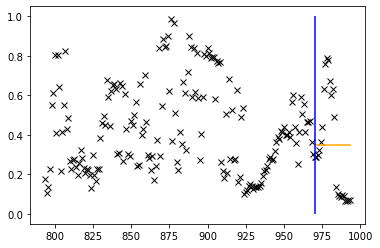

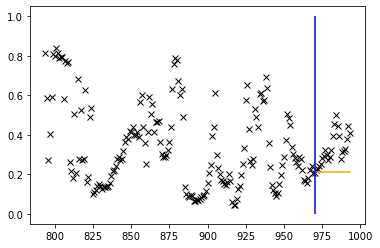

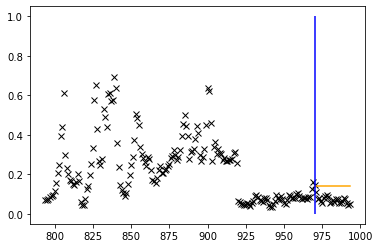

PLOTTING SYSTEM 2


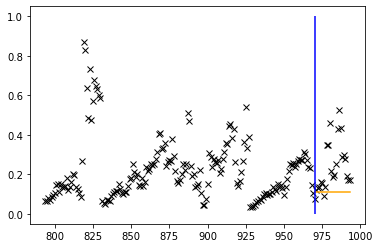

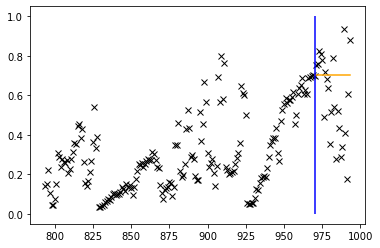

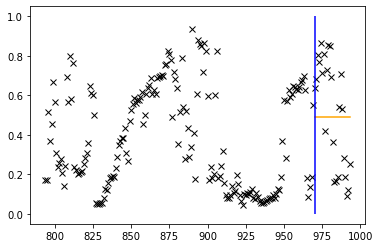

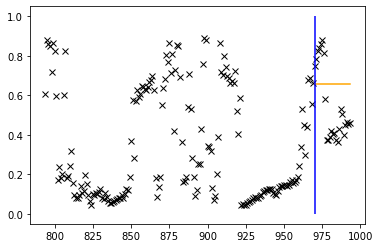

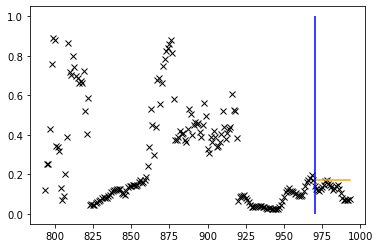

PLOTTING SYSTEM 3


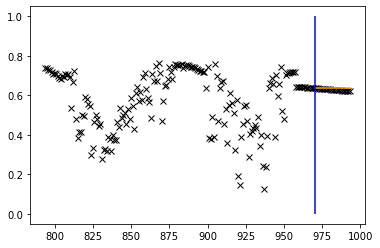

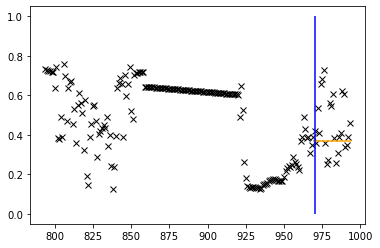

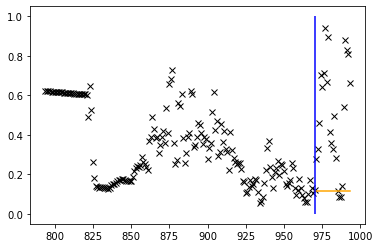

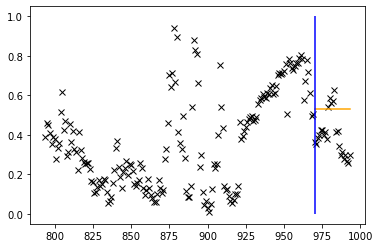

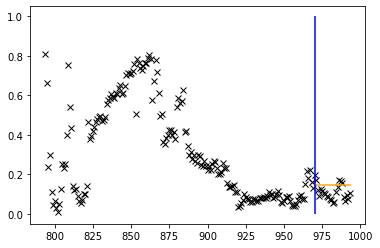

PLOTTING SYSTEM 4


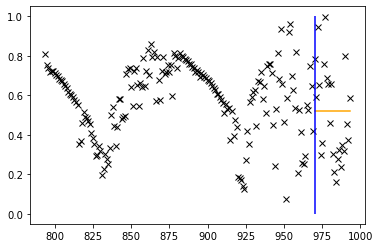

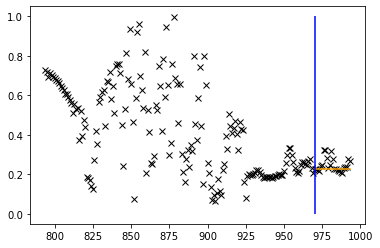

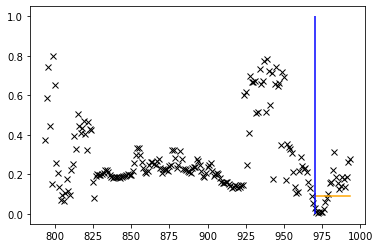

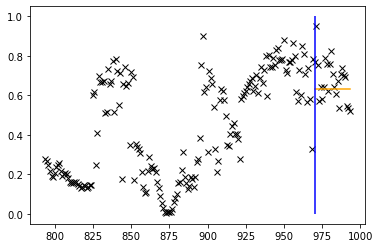

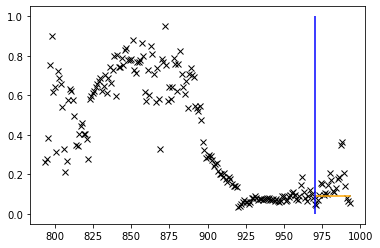

In [213]:
model_type = 'SimpleExpSmoothing'
for ts in range(n_sys_VAR)[:5]:
    print(f'PLOTTING SYSTEM {ts}')
    for i, t in enumerate(range_idx[:5]):
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        plt.plot(data_multiple_iter.reset_index().index[-200:], data_multiple_iter.iloc[:, ts][-200:],  "xk")
        plt.plot(data_multiple_iter.reset_index().index[-24:], predictions_results[model_type][i, :, ts], color = 'orange')
        plt.vlines(data_multiple_iter.reset_index().index[-24], 0, 1, colors='blue')

        plt.show()

PLOTTING SYSTEM 0


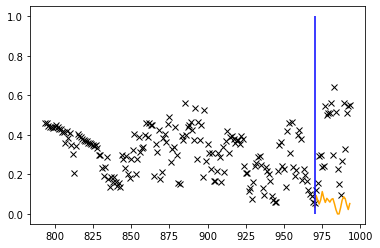

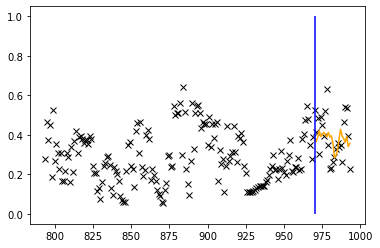

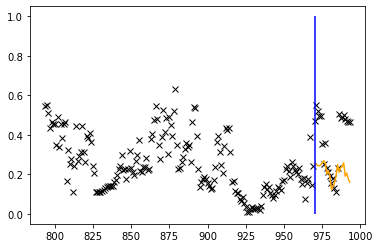

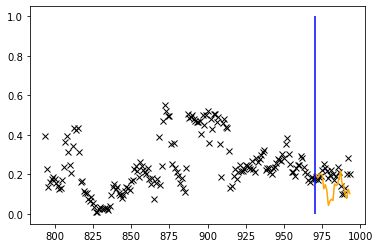

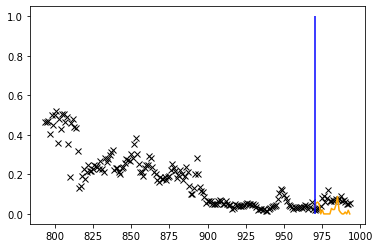

PLOTTING SYSTEM 1


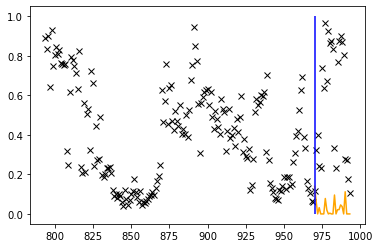

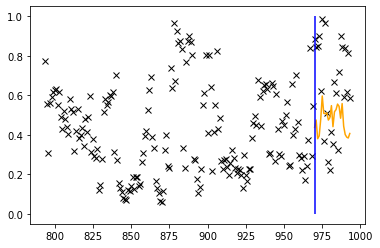

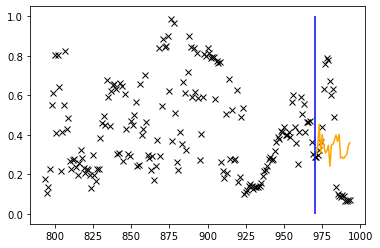

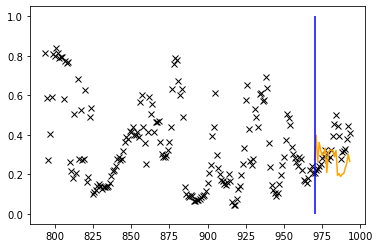

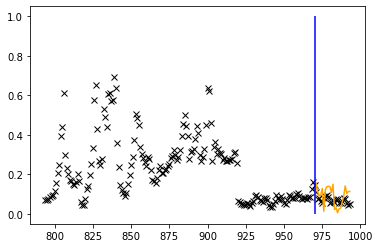

PLOTTING SYSTEM 2


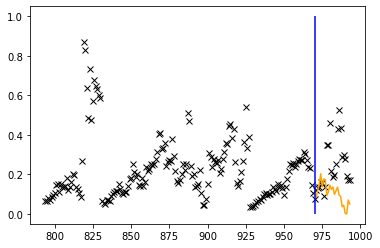

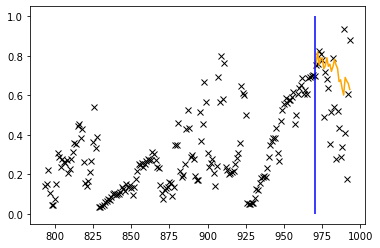

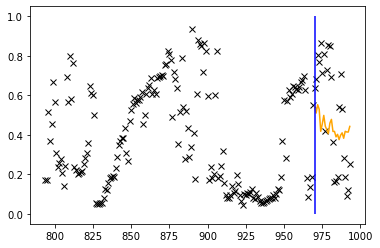

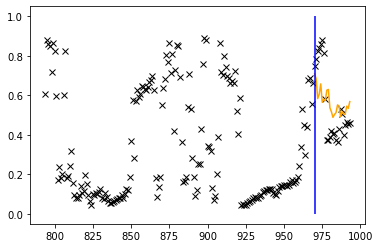

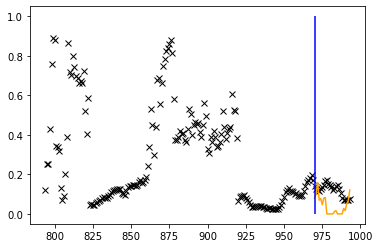

PLOTTING SYSTEM 3


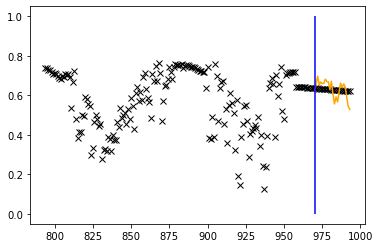

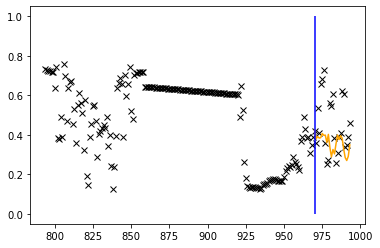

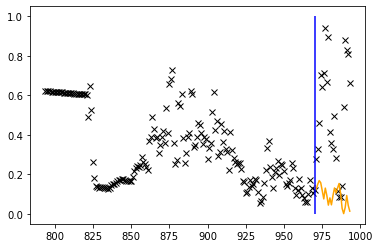

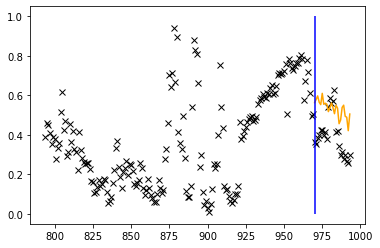

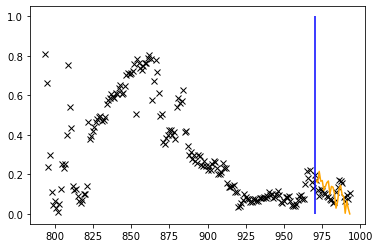

PLOTTING SYSTEM 4


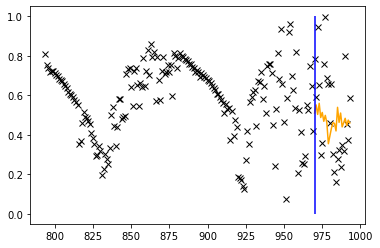

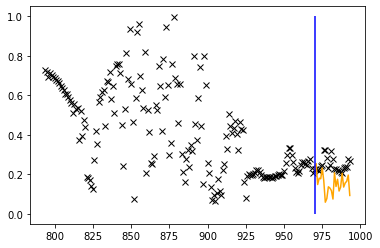

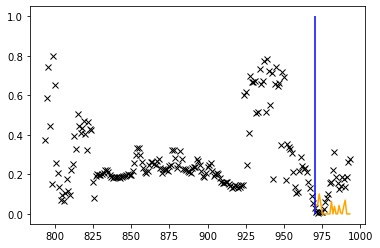

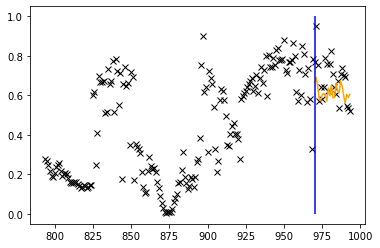

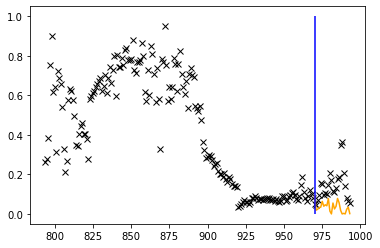

In [214]:
model_type = 'ExponentialSmoothing'
for ts in range(n_sys_VAR)[:5]:
    print(f'PLOTTING SYSTEM {ts}')
    for i, t in enumerate(range_idx[:5]):
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        plt.plot(data_multiple_iter.reset_index().index[-200:], data_multiple_iter.iloc[:, ts][-200:],  "xk")
        plt.plot(data_multiple_iter.reset_index().index[-24:], predictions_results[model_type][i, :, ts], color = 'orange')
        plt.vlines(data_multiple_iter.reset_index().index[-24], 0, 1, colors='blue')

        plt.show()

PLOTTING SYSTEM 0


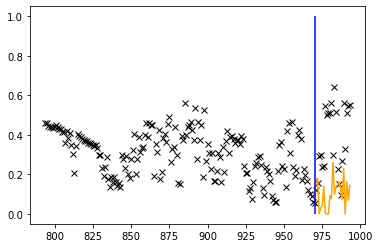

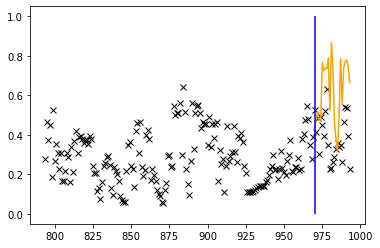

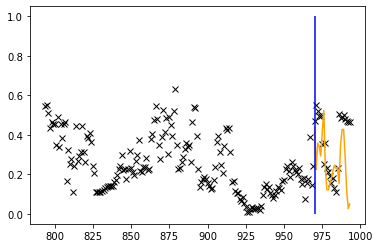

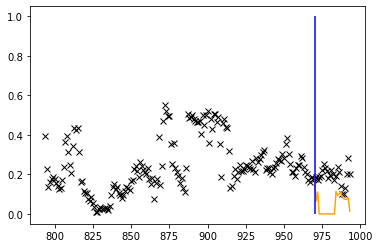

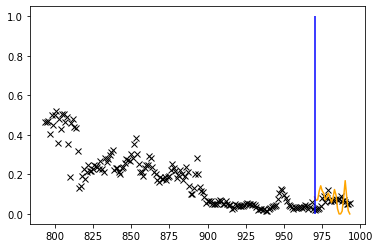

PLOTTING SYSTEM 1


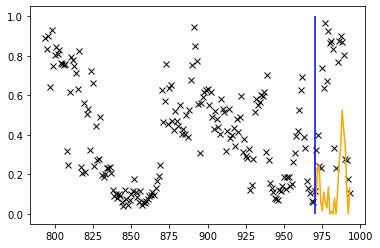

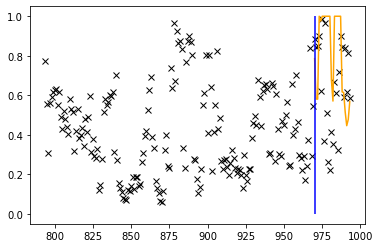

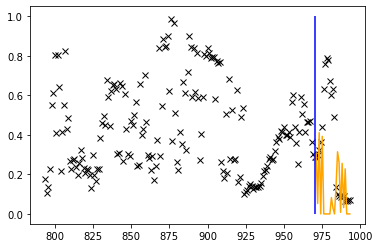

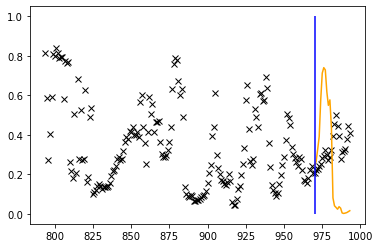

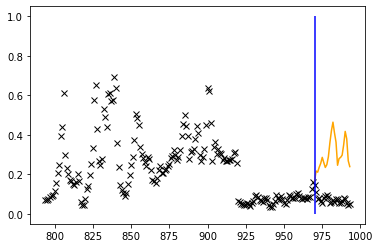

PLOTTING SYSTEM 2


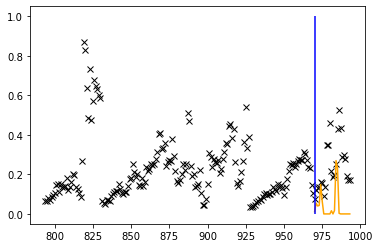

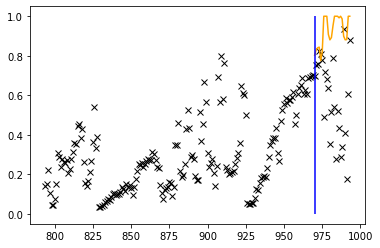

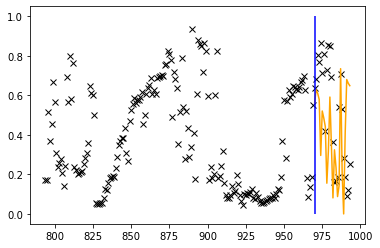

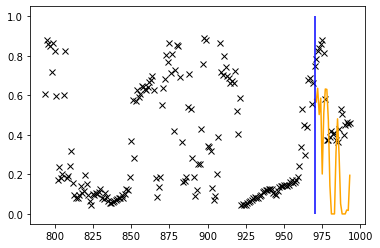

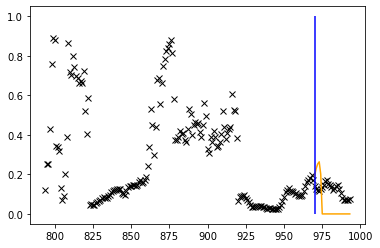

PLOTTING SYSTEM 3


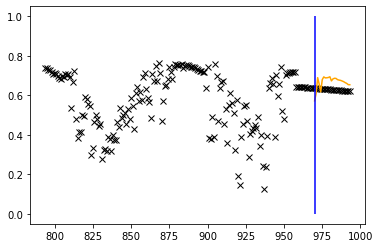

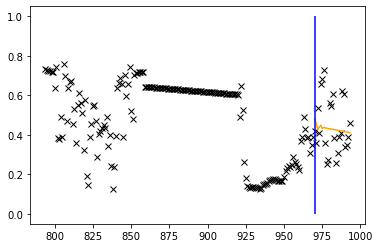

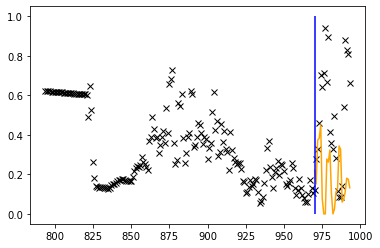

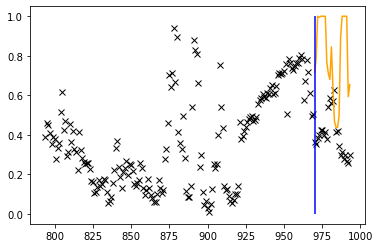

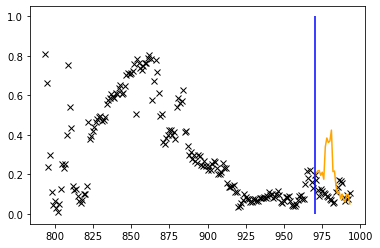

PLOTTING SYSTEM 4


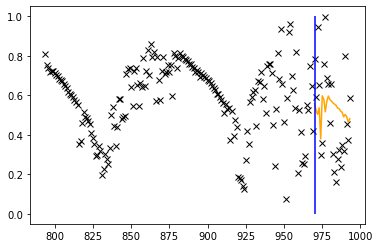

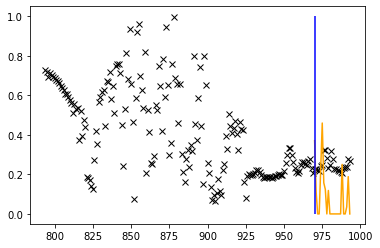

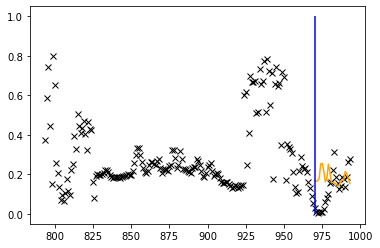

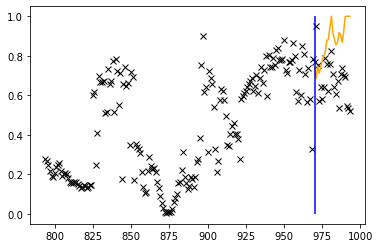

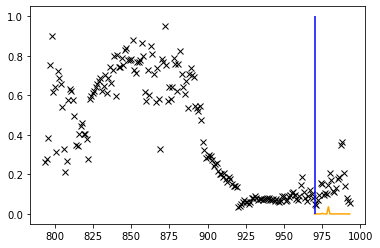

In [216]:
model_type = 'VAR'
for ts in range(n_sys_VAR)[:5]:
    print(f'PLOTTING SYSTEM {ts}')
    for i, t in enumerate(range_idx[:5]):
        data_multiple_iter = data_multiple.iloc[t:t+length_window + 24]
        data_multiple_train = data_multiple_iter.iloc[:length_window] 
        data_multiple_test = data_multiple_iter[length_window:]  

        plt.plot(data_multiple_iter.reset_index().index[-200:], data_multiple_iter.iloc[:, ts][-200:],  "xk")
        plt.plot(data_multiple_iter.reset_index().index[-24:], predictions_results[model_type][i, :, ts], color = 'orange')
        plt.vlines(data_multiple_iter.reset_index().index[-24], 0, 1, colors='blue')

        plt.show()